In this notebook we will simulate thermal unfolding curves with different melting temperatures
and evaluate if we can recover the correct Tm values by fitting the data.

The idea is to find if we can fit Tm, even when it is not observed.

In [1]:
import pychemelt as pychem
import numpy as np
from plotly.subplots import make_subplots

from pychemelt.utils.math import (
    linear_baseline,
    exponential_baseline
)

from pychemelt.utils.plotting import PlotConfig

from scripts import display_figure_static

In [2]:
RNG_SEED = 2

rng = np.random.default_rng(RNG_SEED)

In [3]:
def aux_create_pychem_sim(params):

    concs = np.arange(1,5.5,0.5)

    # Calculate signal range for proper y-axis scaling
    temp_range = np.linspace(20, 90, 100)
    signal_list = []
    temp_list   = []

    for i,D in enumerate(concs):

        y = pychem.signal_two_state_tc_unfolding(temp_range, D, **params)

        # Add gaussian error to simulated signal
        y += rng.normal(0, 0.02, len(y))

        # Add error to the initial signal to model variance across positions
        y *= rng.uniform(0.9,1.1)

        signal_list.append(y)
        temp_list.append(temp_range)

    pychem_sim = pychem.Sample()

    pychem_sim.signal_dic['Simulated signal'] = signal_list
    pychem_sim.temp_dic['Simulated signal']   = [temp_range for _ in range(len(concs))]

    pychem_sim.conditions = concs

    pychem_sim.global_min_temp = np.min(temp_range)
    pychem_sim.global_max_temp = np.max(temp_range)

    pychem_sim.set_denaturant_concentrations()

    pychem_sim.set_signal('Simulated signal')

    pychem_sim.select_conditions(normalise_to_global_max=True)
    pychem_sim.expand_multiple_signal()

    return pychem_sim

In [4]:
def_params = {

     # Thermodynamic parameters

    'DHm': 100, # Enthalpy of unfolding
    'Tm': np.nan, # Temperature of unfolding
    'Cp0': 1, # Heat capacity of unfolding
    'm0': 3, # m-value of unfolding
    'm1': 0, # m-dependence on temperature, not modelled

    # Native baseline parameters

    'p1_N': 2.5,  # dependence on denaturant concentration
    'p2_N': 24,   # intercept
    'p3_N': -0.27,  # slope term
    'p4_N': 0, # quadratic term, ignored

    # Unfolded baseline parameters

    'p1_U': 1.6, # dependence on denaturant concentration
    'p2_U': -4, # intercept
    'p3_U': 80.5, # pre-exponential factor
    'p4_U': 0.0224, # exponential coefficient

    # Baseline functions

    'baseline_N_fx':linear_baseline,
    'baseline_U_fx':exponential_baseline
}


In [5]:
def fit_pychem_sim(pychem_sim_x):

    pychem_sim_x.estimate_baseline_parameters(
        native_baseline_type='linear',
        unfolded_baseline_type='exponential'
    )

    pychem_sim_x.fit_thermal_unfolding_local()

    pychem_sim_x.n_residues = 150 # only for cp initial guess
    pychem_sim_x.guess_Cp()

    pychem_sim_x.fit_thermal_unfolding_global()

    pychem_sim_x.fit_thermal_unfolding_global_global()
    pychem_sim_x.fit_thermal_unfolding_global_global_global(model_scale_factor=True)

    return None

Now we will simulate data with different Tms, fit it, and evaluate the accuracy of the fitted Tms.

In [6]:
pychem_sims_lst = []

Tms = np.arange(70, 130, 10)

for i, Tm in enumerate(Tms):
    params = def_params.copy()
    params['Tm'] = Tm

    pychem_sim = aux_create_pychem_sim(params)
    fit_pychem_sim(pychem_sim)

    pychem_sims_lst.append(pychem_sim)

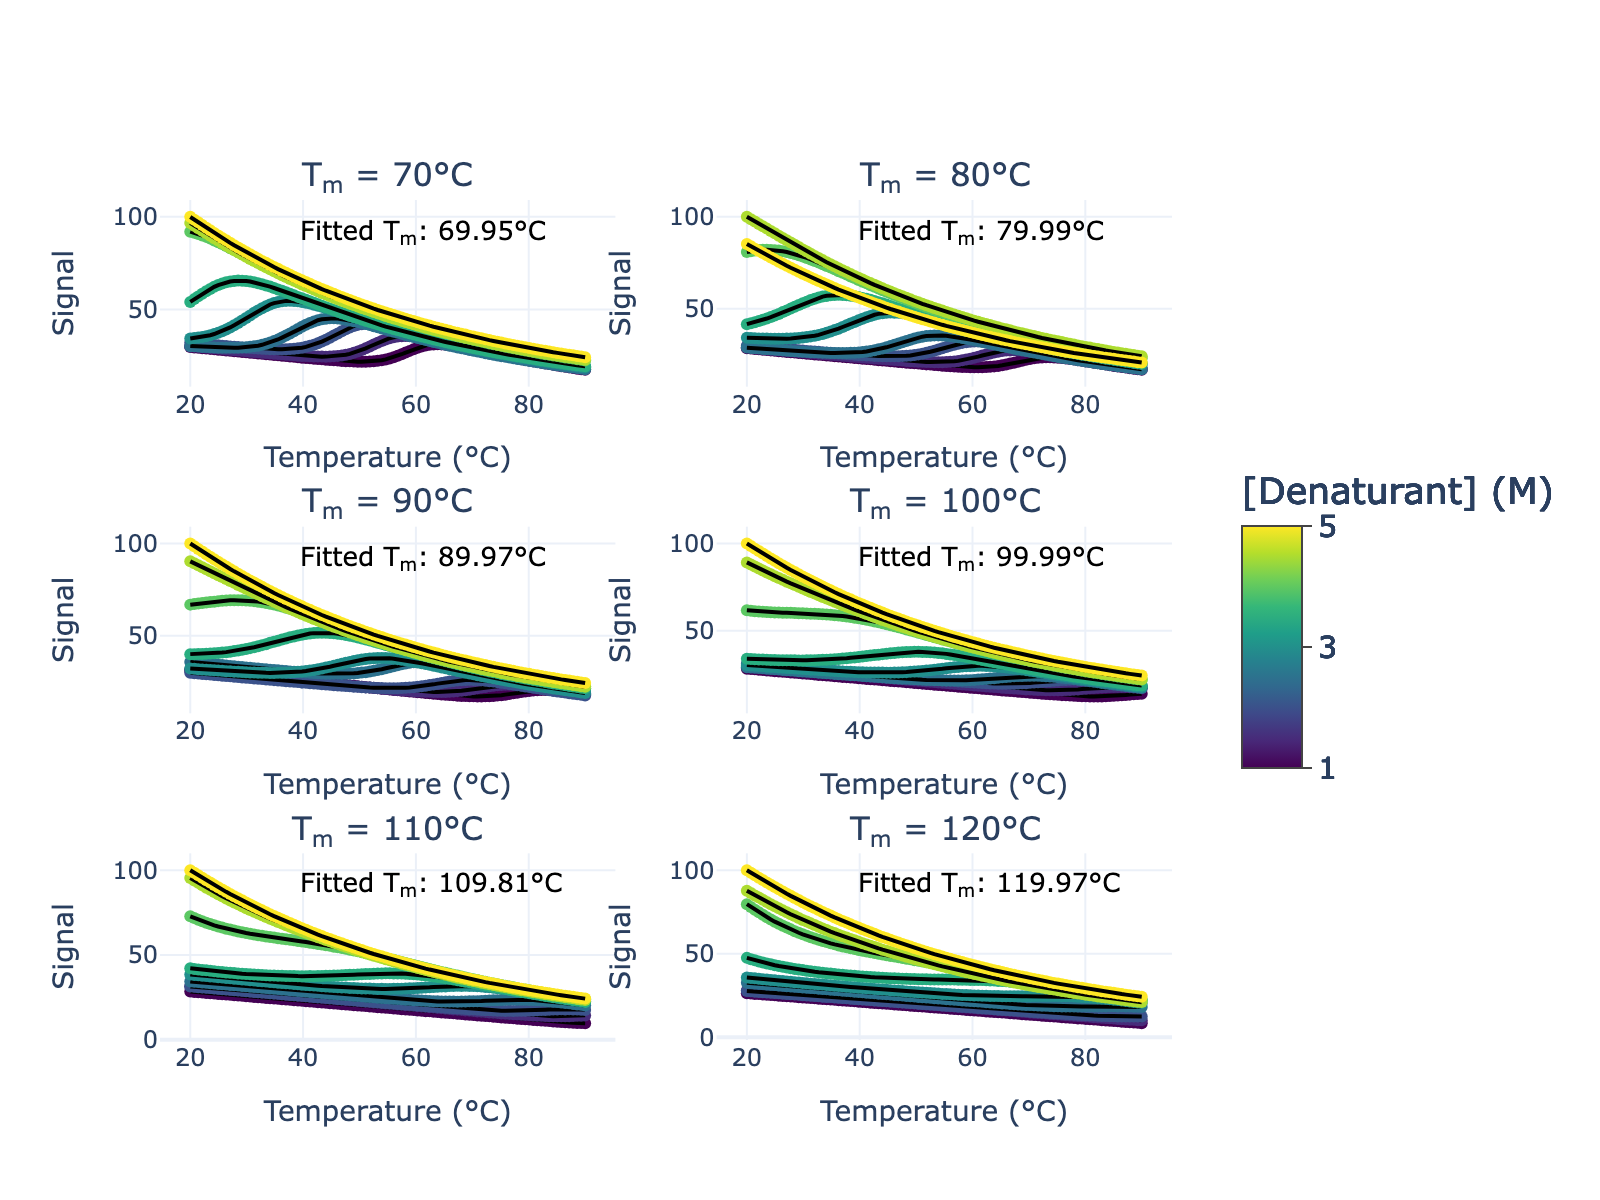

In [7]:
n_plots = len(Tms)
n_cols = 2
n_rows = int(np.ceil(n_plots / n_cols))

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    subplot_titles=[f'T<sub>m</sub> = {Tm}°C' for Tm in Tms]
)

plot_config = PlotConfig()
plot_config.line_width = 2
plot_config.marker_size = 6

for i, Tm in enumerate(Tms):

    pychem_sim = pychem_sims_lst[i]

    # create the plotly figure for this simulation (temporary)

    tmp_fig = pychem.plot_unfolding(pychem_sim,plot_config=plot_config)

    params = pychem_sim.params_df
    fitted_Tm = params.iloc[0, 1]

    row = i // n_cols + 1
    col = i % n_cols + 1

    # Copy all traces into the subplot (once)
    for trace in tmp_fig.data:
        fig.add_trace(trace, row=row, col=col)

    # Add an annotation inside the subplot showing the fitted Tm
    axis_index = i + 1
    # Plotly expects 'x domain'/'y domain' (no '1') for the first axis; for others use 'xN domain'
    if axis_index == 1:
        xref = 'x domain'
        yref = 'y domain'
    else:
        xref = f'x{axis_index} domain'
        yref = f'y{axis_index} domain'

    fig.add_annotation(
        x=0.3,
        y=0.95,
        xref=xref,
        yref=yref,
        text=f'Fitted T<sub>m</sub>: {fitted_Tm:.2f}°C',
        showarrow=False,
        align='left',
        font=dict(size=13, color='black')
    )

# Optional layout tweaks
fig.update_layout(
    height=250 * n_rows,
    width=900,
    showlegend=False
)

fig.update_layout(
    template="plotly_white",
    paper_bgcolor="white",
    plot_bgcolor="white"
)

fig.update_xaxes(title_text="Temperature (°C)")
fig.update_yaxes(title_text="Signal")
fig.write_image("2_evaluate_Tm_fitting.png", scale=2)
display_figure_static(fig)